## Fraud Problem A

Indeed, fraud in real life is often ambiguous. My goal here is **not** to identify fraud with absolute certainty, but rather flag suspicious activity for further follow up. I will explore the data with Python (mostly Pandas). Due to time constrains, my code might the most efficient possible, but it definitely does the job for any reasonably large dataset.

#### Summary of Anomalies
- 2 pairs of identical timestamps
    - One set is made by different persons and the other is made by same person
- All 6 of them have about 20% of their bookings that is less than 5 seconds apart from the last booking
- Ricky and Mamat has half their bookings less than 3 minutes apart from their last booking
- Around 40% of orders accross all 6 agents are made between 12am and 6am

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Let us first explore the first few entries of the data. 

In [186]:
#Parsing the datetime column in datetime formate will facilitate manipulation
prob_a = pd.read_csv('PROBLEM A.CSV', parse_dates = ['Timestamp']).dropna(axis = 1, how = 'all')
print(prob_a.head())

  Agent Name               Timestamp  Driver ID
0      Ricky 2017-05-08 04:30:03.050    1000094
1      Mamat 2017-05-14 16:16:35.368    1001006
2       Tono 2017-05-11 06:36:37.733    1000482
3       Bayu 2017-05-08 04:12:38.463    1000026
4       Lila 2017-05-09 04:48:13.452    1000181


We are given 3 columns: Agent name, timestamp and driver ID. The most obvious anomaly would be duplicate driver ID. Let us first check for that. 

In [187]:
prob_a['Driver ID'].value_counts().head()

1001036    1
1000323    1
1000353    1
1000352    1
1000351    1
Name: Driver ID, dtype: int64

Note that value count function automatically sorts in descending order. Since the value count for the top ID is 1, we know that all driver ID is unique. 

## Consecutive Sign-ups

Next thing to check for is duplicate time stamps. It may be that the go-jek system created 2 entries in error. Let's check for that. 

In [188]:
time_counts = prob_a['Timestamp'].value_counts()
print(time_counts.head())

2017-05-09 04:48:14.219    2
2017-05-11 16:18:09.061    2
2017-05-08 05:40:00.858    1
2017-05-13 09:11:01.428    1
2017-05-10 07:15:02.768    1
Name: Timestamp, dtype: int64


Since like we found entries that has exactly the same timestamps. It seems very strange that few entries are made at exactly the same moment in time. Let's dig deeper before we jump to conclusions!

In [189]:
time_suspect_1 = time_counts.index[0]
time_suspect_2 = time_counts.index[1]

print(prob_a[prob_a['Timestamp'] == time_suspect_1])
print(prob_a[prob_a['Timestamp'] == time_suspect_2])

    Agent Name               Timestamp  Driver ID
408       Bayu 2017-05-09 04:48:14.219    1000191
767       Tono 2017-05-09 04:48:14.219    1000192
    Agent Name               Timestamp  Driver ID
117      Ricky 2017-05-11 16:18:09.061    1000568
555      Ricky 2017-05-11 16:18:09.061    1000567


The first set is made by Bayu and Tono. Possible reasons:
- Coincidence, but unlikely 
- Somehow both of them found a way to register the same driver simultaneously
- System error

The second set is made by the same agent - Ricky. It is impossible for Ricky to sign up 2 unique drivers at one point in time. Possible reasons:
- Ricky engaged someone else to signup drivers and they both coincidentally registered somemone at the exact same time
- Ricky used a computer algorithm to signup driver
- System duplicate error

Regardless, it is worth digging deeper with more data (that we do not have). Driver sign-up information would show a great deal. 

Following the same line of logic, there can also be entries with extremely short time periods apart. I will define a convenience function to find these entries.  

In [190]:
name_set = set(prob_a['Agent Name'])
agent_counts = prob_a['Agent Name'].value_counts()

def suspicious_bookings(secs_apart, data): 
    #returns a dataframe with entries that are spaced less than (secs_apart)
    #Also returns a dictionary with the counts of such entries for each agent and their respective percentage of total bookings
    #input data in pandas df format
    
    cheat_counts= {}
    cheat_df = pd.DataFrame(columns = ['row_index1','row_index2', 'driver_id', 'agent_name', 'secs_bet_booking'])
    
    for name in name_set:
        subset = data[data['Agent Name'] == name]
        subset = subset.sort_values('Timestamp').reset_index()
        cheat_counts[name] = 0
        
        for index, row in subset.iterrows():
            if index != 0:
                row1= subset.iloc[index - 1]
                bet_booking_secs = ((row['Timestamp'] - row1['Timestamp']).total_seconds())
                if bet_booking_secs < secs_apart:
                    cheat_counts[name]+=1
                    cheat_df_1 = pd.DataFrame({'row_index1':row1['index'], 
                                               'row_index2':row['index'], 
                                               'driver_id':row['Driver ID'],
                                               'agent_name':row['Agent Name'], 
                                               'secs_bet_booking':[bet_booking_secs]})
                    cheat_df = pd.concat([cheat_df, cheat_df_1])
                    
    for name in name_set:
        cheat_counts[name] = (cheat_counts[name], '{:.2f}%'.format(cheat_counts[name]/agent_counts[name] * 100))

    return cheat_counts, cheat_df.reset_index().drop('index', axis = 1)

In [191]:
cheat_counts, cheat_df = suspicious_bookings(10, prob_a)
print(cheat_df.head())
print(cheat_counts)

  row_index1 row_index2 driver_id agent_name  secs_bet_booking
0        638        374   1000029      Ricky             0.582
1        374        925   1000034      Ricky             0.361
2        925        559   1000036      Ricky             0.350
3        559        506   1000046      Ricky             1.402
4        654        175   1000064      Ricky             1.283
{'Ricky': (110, '30.14%'), 'Sarah': (27, '22.69%'), 'Lila': (21, '17.65%'), 'Mamat': (52, '27.23%'), 'Tono': (25, '21.19%'), 'Bayu': (27, '21.60%')}


Arguably, it is impossible for agents to simultaneously signup 2 people in a span of 10 seconds, given they have to explain the product to the driver. Possibilities:
- They are signing drivers in groups (couples etc)
- They are using a computer program to create fictitious signups

Let us now extend the window to 3 minutes (180seconds). Logically, it is highly unlikely to register 2 unique drivers in under 3 minutes. One might argue that the agent might be signing up drivers in groups. However, it is extremely suspicious to sign up too many such groups in any given week. 

Thus, our function also log the number of such entries with close proximities for each agent. A percentage of suspicious booking pairs out of total for each agent is also calculated. 

In [192]:
cheat_counts, cheat_df = suspicious_bookings(180, prob_a)
print(cheat_counts)

{'Ricky': (175, '47.95%'), 'Sarah': (29, '24.37%'), 'Lila': (24, '20.17%'), 'Mamat': (102, '53.40%'), 'Tono': (28, '23.73%'), 'Bayu': (29, '23.20%')}


Ricky's and Mamat's entries seems the most suspicious since about 50% of their bookings are made less than 3 minutes after their last bookings. Let us plot graphs to further shed light on the matter.

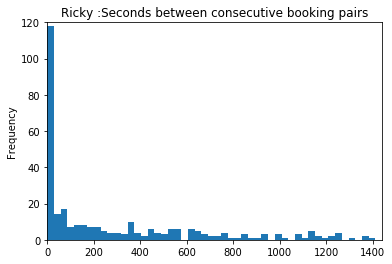

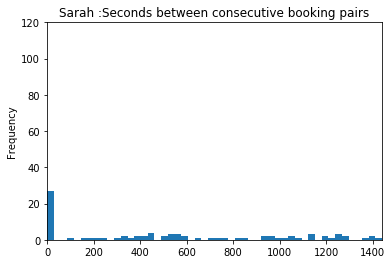

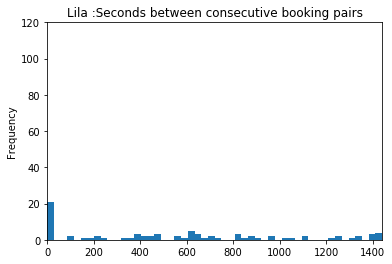

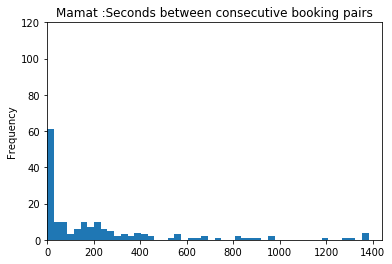

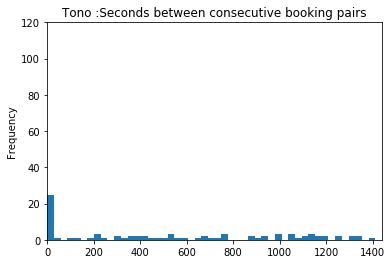

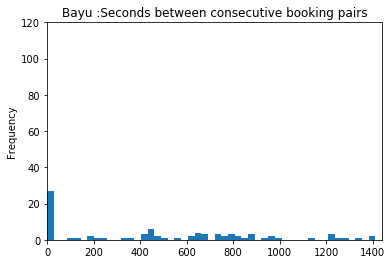

In [193]:
##Returns all entries
for name in name_set:
    all_counts, all_df = suspicious_bookings(np.exp(1e6), prob_a)
    entries = all_df[all_df['agent_name'] == name]
    time_bet = entries['secs_bet_booking'] 
    time_bet.plot.hist(bins = 50, range = (0, 1440)) #1440seconds =  24 hours
    plt.title(name +' :Seconds between consecutive booking pairs')
    plt.axis((0,1440 ,0,120))
    plt.show()

Indeed, Ricky's and Mamat's entries seems extremely suspicious. Possibilities:
- It is a coincidence and they meet more groups than individual (unlikely!)
- They are cheating and they signup multiple times in short durations themselves or with the help of others.

## Sophisticated Cheaters

What if they are way more sophisticated than we think they are? Did they enlisted the help of programmers to write a program to periodically signup? We have to dig deeper to check if there are identically spaced signups. To do this, we use value_counts on the time intervals between bookings. If there is a fixed interval account sign-up pattern, we should have a very skewed value_count distribution. 

In [194]:
print(all_df['secs_bet_booking'].value_counts().head())

0.022    6
0.026    5
0.025    5
0.027    5
0.029    4
Name: secs_bet_booking, dtype: int64


Based on the signup information, there is no fixed interval for most bookings. However, this may mean that they are factoring in randomness. 

Another way to check for automated cheating would be to check the percentage of signups that fall during human hours (i.e. 6am to 12am midnight ). Over here, we are assuming that drivers and agents fall in the same timezone.

{'Ricky': (103, '28.22%'), 'Sarah': (54, '45.38%'), 'Lila': (50, '42.02%'), 'Mamat': (42, '21.99%'), 'Tono': (53, '44.92%'), 'Bayu': (58, '46.40%')}


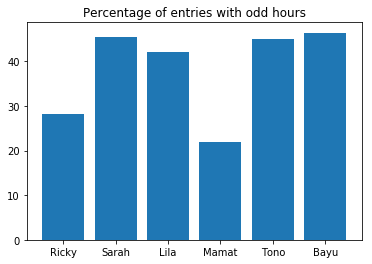

In [197]:
name_set = set(prob_a['Agent Name'])
agent_count = prob_a['Agent Name'].value_counts()

prob_a['odd_hours'] = prob_a['Timestamp'].apply(lambda stamp: True if stamp.hour<6 else False)
group_count = prob_a['Agent Name'][prob_a['odd_hours']].value_counts()
perc_dict = {}

for name in name_set:
    perc_dict[name] = group_count[name]/agent_count[name] * 100
    odd_hour_dict[name] = (group_count[name], '{:.2f}%'.format(perc_dict[name]))

print(odd_hour_dict)

plt.bar(x = list(perc_dict.keys()), height = list(perc_dict.values()))
plt.title('Percentage of entries with odd hours')
plt.show()